In [1]:
import os
from shutil import copy2
import numpy as np
import utils
from scipy.misc import imsave
from scipy.ndimage import imread
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import io

In [3]:
print(train_arr.shape, mask_arr.shape)

(256, 256, 4) (256, 256)


In [3]:
# copy train_image to destination
path = "../data/stage1_train/"
for x in os.listdir(path):
    if x != ".DS_Store":
        copy2(path + x + "/images/" + x + ".png", "../data/stage1_train_images/")

In [10]:
!ls ../data/stage1_train_images/ | wc 

     670     670   46230


In [11]:
# copy test
path = "../data/stage1_test/"
for x in os.listdir(path):
    if x != ".DS_Store":
        copy2(path + x + "/images/" + x + ".png", "../data/stage1_test_images/")

In [9]:
"""extend the given ndarry in shape H*W*C to 9 times in shape 3H*3W*C 
    The 2D transformation view is as:
    from: |---|---|
          | A | B |
          |---|---|
          | C | D |
          |---|---|
    to:   
          |---|---|---|---|---|---|
          | d | c | c | d | d | c |
          |---|---|---|---|---|---|
          | b | a | a | b | b | a |
          |---|---|---|---|---|---|
          | b | a | A | B | b | a |
          |---|---|---|---|---|---|
          | d | c | C | D | d | c |
          |---|---|---|---|---|---|
          | d | c | c | d | d | c |
          |---|---|---|---|---|---|
          | b | a | a | b | b | a |
          |---|---|---|---|---|---|
    """
origin = np.array([[['a1', 'a2', 'a3'],['b1', 'b2','a3']],[['c1', 'c2','a3'],['d1', 'd2','a3']]])

print("----------------------origin--------------------------------")
print(origin)
print(origin.shape)
print(origin[:,:,0])
print(origin[:,:,1])

print("----------------------horizontal--------------------------------")
horizontal = np.fliplr(origin)
print(horizontal.shape)
print(horizontal[:,:,0])
print(horizontal[:,:,1])

print("----------------------vertical--------------------------------")
vertical = np.flipud(origin)
print(vertical.shape)
print(vertical[:,:,0])
print(vertical[:,:,1])

print("----------------------cornor--------------------------------")
cornor = np.flipud(horizontal)
print(cornor.shape)
print(cornor[:,:,0])
print(cornor[:,:,1])

print("----------------------row1--------------------------------")
row1 = np.concatenate((cornor,vertical,cornor), axis=1)
print(row1.shape)
print(row1[:,:,0])
print(row1[:,:,1])

print("----------------------row2--------------------------------")
row2 = np.concatenate((horizontal,origin,horizontal), axis=1)
print(row2.shape)
print(row2[:,:,0])
print(row2[:,:,1])

print("----------------------row3--------------------------------")
row3 = np.concatenate((cornor,vertical,cornor), axis=1)
print(row3.shape)
print(row3[:,:,0])
print(row3[:,:,1])

print("----------------------final--------------------------------")
final = np.concatenate((row1,row2,row3), axis=0)
print(final.shape)
print(final[:,:,0])
print(final[:,:,1])

def extend_sides(origin):
    MARGIN = 1
    horizontal = np.fliplr(origin)
    vertical = np.flipud(origin)
    cornor = np.flipud(horizontal)
    row1 = np.concatenate((cornor,vertical,cornor), axis=1)
    row2 = np.concatenate((horizontal,origin,horizontal), axis=1)
    row3 = np.concatenate((cornor,vertical,cornor), axis=1)
    full_size = np.concatenate((row1,row2,row3), axis=0)
    H, W, _ = origin.shape
    H_S = H - MARGIN
    W_S = W - MARGIN
    H_E = 2*H + MARGIN
    W_E = 2*W + MARGIN
    final = full_size[H_S:H_E, W_S:W_E, :]
    return final

a  = extend_sides(origin)
print(a.shape)
print(a[:,:,0])
print(a[:,:,1])

In [4]:
# seek max resolution
max_h=0
max_w=0
min_h=99999
min_w=99999
for image_id in utils.TRAIN_IMAGE_IDS:
  h,w,_ = utils.image2ndarry(image_id, training=True).shape
  if h > max_h : max_h = h
  if w > max_w : max_w = w
  if h < min_h : min_h = h
  if w < min_w : min_w = w
print(max_h, max_w)
print(min_h, min_w)

1040 1388
256 256


In [25]:
# slice images into 256x256
image_dst = utils.DATA_ROOT + "stage1_train_256x256/images/"
mask_dst = utils.DATA_ROOT + "stage1_train_256x256/masks/"
os.system("rm {}*".format(image_dst))
os.system("rm {}*".format(mask_dst))
image_ids = [x.split('.')[0] for x in os.listdir(utils.DATA_ROOT + "stage1_train_images/") if x.endswith(".png")]
for image_id in image_ids:
    img_np = imread(utils.DATA_ROOT + "stage1_train_images/" + image_id + ".png")
    H,W,C = img_np.shape
    mask_np = utils.mask2ndarry(image_id, H, W)
    if H < 256 or W < 256:
        print("image {} size is {}x{}x{}, this program can't handle".format(image_id, H, W, C) )
    elif H == 256 and W == 256:
        # save, not slice
        imsave(image_dst + image_id + ".png", img_np)
        imsave(mask_dst + image_id + ".png", mask_np)
    else:
        for h in range(0, H, 256):
            if h+256 <= H:
                start_h = h
                end_h = h+256
            else:
                start_h = H - 256
                end_h = H
            for w in range(0, W, 256):
                if w+256 <= W:
                    start_w = w
                    end_w = w+256
                else:
                    start_w = W - 256
                    end_w = W
                slice_img = img_np[start_h:end_h, start_w:end_w, :]
                imsave(image_dst + image_id +"_"+str(start_h)+"_"+str(start_w) + ".png", slice_img)
                slice_mask = mask_np[start_h:end_h, start_w:end_w, :]
                imsave(mask_dst + image_id +"_"+str(start_h)+"_"+str(start_w) + ".png", slice_mask)

In [3]:
# slice class images into 256x256
image_dst = utils.DATA_ROOT + "stage1_train_class_256x256/images/"
mask_dst = utils.DATA_ROOT + "stage1_train_class_256x256/masks/"
os.system("rm {}*".format(image_dst))
os.system("rm {}*".format(mask_dst))

for label in os.listdir(utils.DATA_ROOT + "stage1_train_images/"):
    if label != ".DS_Store":
        image_ids = [x.split('.')[0] for x in os.listdir(utils.DATA_ROOT + "stage1_train_images/" + label) if x.endswith(".png")] 
        for image_id in image_ids:
            img_np = imread(utils.DATA_ROOT + "stage1_train_images/"+ label + "/" + image_id + ".png")
            H,W,C = img_np.shape
            mask_np = utils.mask2ndarry(image_id, H, W)
            if H < 256 or W < 256:
                print("image {} size is {}x{}x{}, this program can't handle".format(image_id, H, W, C) )
            elif H == 256 and W == 256:
                # save, not slice
                imsave(image_dst + image_id + "_" + label  + ".png", img_np)
                imsave(mask_dst + image_id + "_" + label + ".png", mask_np)
            else:
                for h in range(0, H, 256):
                    if h+256 <= H:
                        start_h = h
                        end_h = h+256
                    else:
                        start_h = H - 256
                        end_h = H
                    for w in range(0, W, 256):
                        if w+256 <= W:
                            start_w = w
                            end_w = w+256
                        else:
                            start_w = W - 256
                            end_w = W
                        slice_img = img_np[start_h:end_h, start_w:end_w, :]
                        imsave(image_dst + image_id + "_" + label +"_"+str(start_h)+"_"+str(start_w) + ".png", slice_img)
                        slice_mask = mask_np[start_h:end_h, start_w:end_w, :]
                        imsave(mask_dst + image_id + "_" + label +"_"+str(start_h)+"_"+str(start_w) + ".png", slice_mask)

In [27]:
# verify
verify_id = "4a424e0cb845cf6fd4d9fe62875552c7b89a4e0276cf16ebf46babe4656a794e"
img_before = imread(utils.DATA_ROOT + "stage1_train_images/" + verify_id + ".png")
img_after = imread(image_dst + verify_id + ".png")
print(img_before.all() == img_after.all())
mask_before = utils.mask2ndarry(verify_id, img_before.shape[0], img_before.shape[1])
mask_after = imread(mask_dst + verify_id + ".png")
print(mask_before.all() == mask_after.all())

True
True


In [8]:
# classify train data by image size
from scipy.ndimage import imread
path = "../data/stage1_train_images/"
dst_root = "../data/stage1_train_size_classifier/"
for label in os.listdir(path):
    if label != ".DS_Store":
        for x in os.listdir(path + label):
            if not os.path.isdir(path + label + "/" + x) and x != ".DS_Store":
                h,w,_ = imread(path + label + "/" + x).shape
                folder = str(h) + 'x' + str(w)
                if not os.path.exists(dst_root + folder):
                    os.mkdir(dst_root + folder)
                copy2(path + label + "/" + x, dst_root + folder)

In [ ]:
# classify test data by image size
from scipy.ndimage import imread
path = "../data/stage1_test_images/"
dst_root = "../data/stage1_test_size_classifier/"
for x in os.listdir(path):
    if not os.path.isdir(path + x):
        h,w,_ = imread(path + x).shape
        folder = str(h) + 'x' + str(w)
        if not os.path.exists(dst_root + folder):
            os.mkdir(dst_root + folder)
        copy2(path + x, dst_root + folder)

In [13]:
# label 2 list
path = "../data/stage1_train_label_images/2/"
label2_list = []
for each in os.listdir(path):
    if each.endswith(".png"):
        label2_list.append(each.split(".")[0])

In [60]:
# sort as image size
tmp_dict = {}
l = [x.split(".")[0] for x in os.listdir("../data/stage1_train_label_images/2/") if x.endswith(".png")]
for each in l:
  h, w, _ = utils.image2ndarry(each, "train").shape
  key = "{}_{}".format(str(h), str(w))
  if tmp_dict.get(key) is None:
    print(h, w)
    tmp_dict[key] = (each, )
  else:
    tmp_dict[key] += (each, )

TRAIN_IMAGE_IDS = []
for k, v in tmp_dict.items():
  cnt = 0
  for each in v:
    TRAIN_IMAGE_IDS.append(each)
    cnt += 1
  print("{} images in size {} added".format(cnt, k))
np.save("../data/sroted_TRAIN_IMAGE_IDS.npy", TRAIN_IMAGE_IDS)

256 256
520 696
360 360
512 640
603 1272
260 347
256 320
1040 1388
334 images in size 256_256 added
92 images in size 520_696 added
91 images in size 360_360 added
13 images in size 512_640 added
6 images in size 603_1272 added
5 images in size 260_347 added
4 images in size 256_320 added
1 images in size 1040_1388 added


In [65]:
l = [x.split(".")[0] for x in os.listdir("../data/stage1_test_label_images/2/") if x.endswith(".png")]
np.save("../data/LABEL2_TEST_IMAGE_IDS.npy", np.array(l))

In [32]:
# erode masks
def stack_mask(image_id, erode):
    p = Path("../data/stage1_train") / image_id / "masks"
    mask_img = None
    for each_mask in os.listdir(p):
        if each_mask.endswith(".png"):
            mask_tmp = cv2.imread(str(p / each_mask))[:, :, 0]
            mask_tmp2 = np.copy(mask_tmp)
            if erode:
                _, contours, hierarchy = cv2.findContours(mask_tmp2, 1, 2)
                # contour ->  color: 100
                # 0-background, 255-forground
                _ = cv2.drawContours(mask_tmp2, contours,
                                     contourIdx = -1, color = 100, thickness = 1)
            if mask_img is None:
                mask_img = mask_tmp2
            else:
                mask_img += mask_tmp2
    return mask_img

In [33]:
res = []
for img_id in utils.TRAIN_IMAGE_IDS:
    mask_erode = stack_mask(img_id, erode=True)
    mask_origin  = stack_mask(img_id, erode=False)
    # https://stackoverflow.com/questions/35854197/how-to-use-opencvs-connected-components-with-stats-in-python
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
                                    mask_erode, connectivity = 4, centroids = cv2.CV_32S)
    res.append([img_id, len(utils.obj_select(img_id)), num_labels - 1])
    # save images
    imsave("../data/stage1_train_erode_mask/{}.png".format(img_id), mask_erode)

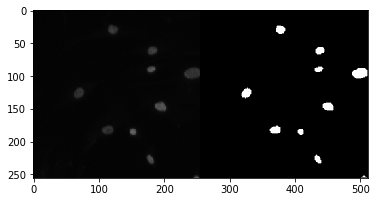

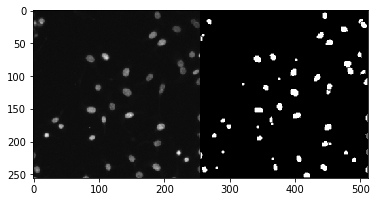

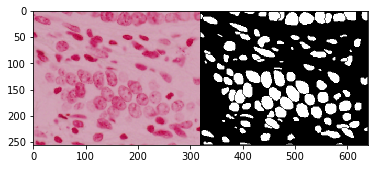

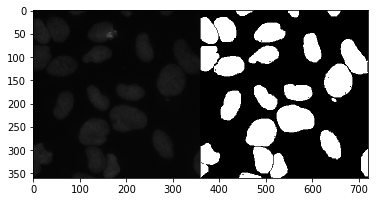

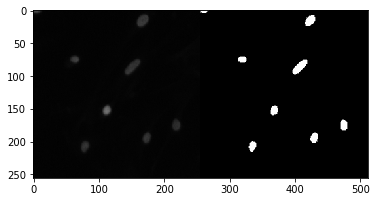

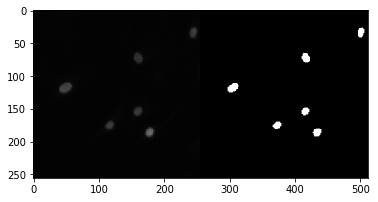

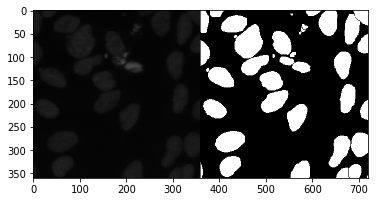

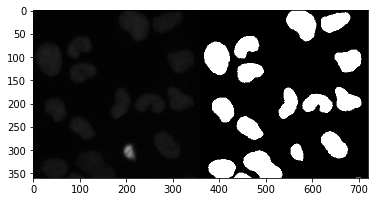

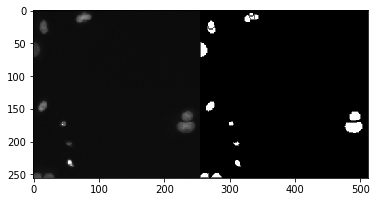

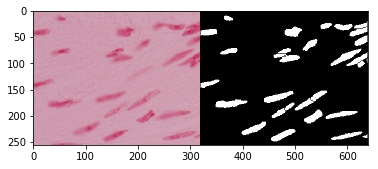

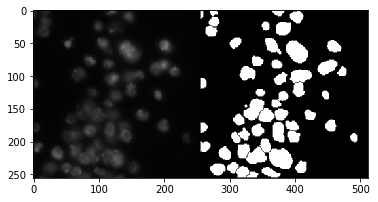

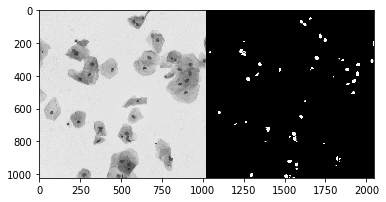

In [34]:
# verify
p = Path("../data")
show_every = 60
i = 0
for each_img in os.listdir(p / "stage1_train_images"):
    if each_img.endswith(".png"):
        img = cv2.imread(str(p / "stage1_train_images" / each_img))
        mask = cv2.imread(str(p / "stage1_train_erode_mask" / each_img))
        if i % show_every == 0:
            plt.imshow(np.concatenate((img, mask), axis=1))
            plt.show()
        i += 1

In [53]:
np.unique(mask, return_counts=True)

(array([  0, 100, 255], dtype=uint8), array([178119,   6360,  12129]))

In [14]:
test_scope

['f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb',
 '697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808',
 '31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a',
 '519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0',
 'fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e1751a9d412a14ab5e3',
 'bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d',
 '4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee',
 '505bc0a3928d8aef5ce441c5a611fdd32e1e8eccdc15cc3a52b88030acb50f81',
 '3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26',
 '8b59819fbc92eefe45b1db95c0cc3a467ddcfc755684c7f2ba2f6ccb9ad740ab',
 '17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff',
 '550450e4bff4036fd671decdc5d42fec23578198d6a2fd79179c4368b9d6da18',
 '43a71aeb641faa18742cb826772a8566c6c947d7050f9ab15459de6cc2b3b6af',
 '0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466',
 '7f4cbe0b36b5d09466476a7d4e01f4f9

In [17]:
if "f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb" in test_scope:
    print("exist")
    test_scope.remove("f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb")

In [20]:
path="../data/test_result/"
test_scope = [x for x in os.listdir("../data/stage1_test_images/") if x.endswith(".png")]
with io.open("../data/stage1_submission.csv", 'w') as f:
    f.write("ImageId,EncodedPixels\n")
    for img_name in os.listdir(path):
        if img_name in test_scope:
            test_scope.remove(img_name) 
        tmp = imread("{}{}".format(path, img_name))
        threshold = 100
        img = np.where(tmp > threshold, 1, 0).astype('uint8')
        num_labels, labels, _, _ = cv2.connectedComponentsWithStats(
                                            img, connectivity = 4, centroids = cv2.CV_32S)
        labels = labels.T.flatten().tolist()
        r_l = {} # {1: [(10, 2), (20, 5)...], 2:[...]}
        length = 0
        prev = None
        start = None
        for i in range(len(labels)):
            cur = labels[i]
            if cur > 0 and prev is None:
                length += 1
                start = i
                prev = cur
            elif prev == cur:
                length += 1
            elif cur == 0 and length > 0:
                if r_l.get(prev) is None:
                    r_l[prev] = [(start, length)]
                else:
                    r_l[prev].append((start, length))
                length = 0
                prev = None
                start = None
        for k, v in r_l.items():
            obj = ""
            for (start, length) in v:
                obj += str(start) + " " + str(length) + " "
            output = (img_name.split(".")[0] + "," + obj).strip()
            f.write(output+"\n")
    for each in test_scope:
        output = each.split(".")[0] + ",1 1"
        f.write(output+"\n")
        print("add {}".format(each))

add f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb.png
add 3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26.png
add 17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff.png
add 0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466.png
add 259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4.png
add 1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1.png
add 9f17aea854db13015d19b34cb2022cfdeda44133323fcd6bb3545f7b9404d8ab.png
add da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab.png
add c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb.png
add 472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71.png
add b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3.png
add 44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078.png


In [7]:
utils.TRAIN_LABEL_CSV = utils.DATA_ROOT + "stage1_submission.csv"

In [8]:
img_name = "0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5"
img = imread(path + img_name + ".png")
H, W  = img.shape
arr = utils.mask2ndarry(img_name, H, W)

In [9]:
arr.shape

(256, 256)

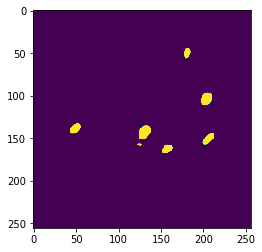

In [10]:
plt.imshow(img)
plt.show()

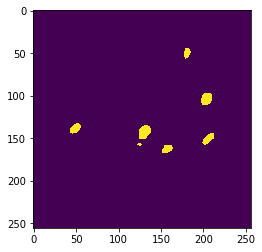

In [11]:
plt.imshow(arr)
plt.show()